# Test Image Transfer Functions

In [1]:
import sys
#sys.path.append('../shared/')
#import videodisko as vd
# Imports
import numpy as np
import numpy.matlib
import numpy.random

from mpl_toolkits.mplot3d import axes3d 

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
import scipy.io
import skimage
import imageio
import colour as c
import math
import csv

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd

import cv2
import time

from datetime import datetime

import os
from fnmatch import fnmatch
import os
from fnmatch import fnmatch
from matplotlib.patches import Rectangle
import re

In [2]:

## Linear to sRGB
def lin2srgb (x):
    result = (x <= 0.0031308) * np.multiply(x,12.92) + (x > 0.0031308) * np.subtract(np.multiply(1.055,np.power(x,(1/2.4))),0.055)
    return result


## sRGB to Linear 
def srgb2lin (x):
    result = (x <= 0.04045) * np.divide(x,12.92) + (x > 0.04045) * np.power(np.divide(np.add(x,0.055),1.055),2.4)
    return result

# SDR Formulas

## Input Luminance between 0-1
## Output Videosignal
def oetf709(x): 
    return np.subtract(np.multiply(np.power(x, 0.45), 1.099), 0.099)*(0.018<= x) + np.multiply(4.5, x) * (x <0.018)

def eotf1886(x, Lw = 100, Lb = 0): 
    gamma = 2.4
    a = np.power(np.subtract(np.power(Lw, np.divide(1,gamma)),np.power(Lb, np.divide(1, gamma))), gamma)
    b = np.divide(np.power(Lb, np.divide(1,gamma)) , np.subtract(np.power(Lw , np.divide(1,gamma)), np.power( Lb , np.divide(1, gamma))))
    return np.multiply(a , np.power( np.maximum(np.add(x, b), 0) , gamma))

def eotf1886_CRT(x, Lw = 100, Lb = 0, b = 0): 
    Vc = 0.35
    a1 = 2.6
    a2 = 3.0
    k = np.subtract(Lw,np.power(np.add(1,b),a1))
    return (x < Vc) * np.multiply(np.multiply(k,np.power(np.add(Vc,b),np.subtract(a1,a2))),np.power(np.add(x,b),a2)) + (Vc <= x) * np.multiply(k,np.power(np.add(x,b),a1))

## Luma Formulas for Rec2020 / Rec709 -> Fixed Addition
def luma709(img): 
    return np.multiply(img[:,:,0],0.2126) + np.multiply(img[:,:,1],0.7152) + np.multiply(img[:,:,2],0.0722)
def luma2020(img): 
    return np.multiply(img[:,:,0],0.2627) + np.multiply(img[:,:,1],0.6780) + np.multiply(img[:,:,2],0.0593)

## Formulas for PQ

# increasing rec.709 formulas 
def steroids709(x): 
    return np.subtract(np.multiply(np.power(np.multiply(59.5208 , x), 0.45), 1.099), 0.099)*(0.0003024< x) + np.multiply(267.84, x) * (x <= 0.0003024)

def steroids1886(x): 
    return np.multiply(100, np.power(x, 2.4))


## Transportfunctions

def pq_eotf(x): 
    ##m1
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    
    return np.multiply(np.power(np.divide(np.maximum( np.subtract( np.power(x , np.divide(1 , m2)), c1) , 0) , np.subtract(c2, np.multiply(c3 , np.power(x , np.divide(1 , m2))))) , np.divide(1, m1)), 10000)

## Inverse_eotf

def pq_eotf_inv(x): 
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    y = np.divide(x , 10000) ## Normalisierung auf 0.00 bis 1.0

    return np.power( np.divide(np.add(c1 , np.multiply(c2 , np.power(y , m1))), np.add(1 , np.multiply(c3 , np.power(y , m1)))), m2)

# RGB Input
def hlg_oetf(x): 
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))

    return np.where(x <= np.divide(1,12), np.sqrt(np.multiply(3,x )), np.add( np.multiply(a , np.log(np.subtract( np.multiply(12 , x ), b))) , c) )

def hlg_oetf_inv(x):
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))
    
    return np.where(x <= 0.5 , np.divide( np.power(x,2), 3), np.divide(np.add(np.exp(np.divide(np.subtract(x , c), a)), b) , 12) )

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf(x, Lw): 
    r = x[: , : , 0]
    g = x[: , : , 1]
    b = x[: , : , 2]
    luma = np.add(np.multiply(0.2627 ,r ), np.multiply(0.678 , g), np.multiply(0.0593 , b))
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    rd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), r)
    gd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), g)
    bd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), b)
    return np.stack((rd , gd , bd))

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf_bw(x, Lw=1000): 
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    return np.multiply(np.multiply( alpha , np.power(x , np.subtract(gamma , 1))),x)

def hlg_eotf(x, Lw = 1000, Lb = 0.005):
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    beta = np.sqrt(np.multiply(3 , np.power(np.divide(Lb , Lw), np.divide(1,gamma))))
    return hlg_ootf_bw(hlg_oetf_inv(np.maximum(0 , (np.add( np.multiply( np.subtract(1 , beta), x ), beta)))), Lw)


def slog3oetf(x): 
    # reflection add
    x = x*0.9

    return (x < 0.01125)* np.divide( np.add( np.multiply(x , np.divide(np.subtract(171.2102946929, 95), 0.01125)), 95), 1023) + (x >= 0.01125)* np.divide(np.add(420 , np.multiply( np.log10(np.divide(np.add(x,0.01), np.add(0.18, 0.01))), 261.5)), 1023)

def slog3eotf(x): 
    return (x >= np.divide(171.2102946929,1023)) * np.subtract( np.multiply(np.power(10 , np.divide( np.subtract(420 , np.multiply(x , 1023)) , 261.5)) , np.add(0.18 , 0.01)) , 0.01) + (x < np.divide(171.2102946929,1023)) * np.multiply(np.subtract(np.multiply(x , 1023), 95 ) , np.divide(0.01125 , np.subtract(171.2102946929 , 95)))

# These are the ARRI LogCv3 Formulas
def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)
def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)


### LOG C4
def Encoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < t) * np.divide(np.subtract(x,t),s) + (x >= t) * np.add(np.multiply(np.divide( np.subtract(np.log2(np.add(np.multiply(a,x),64.0)),6.0),14.0),b),c)

def Decoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < 0.0) * np.add(np.multiply(x,s),t) + (x >= 0.0) * np.divide(np.subtract(np.power(2.0, np.add(np.multiply(14,np.divide(np.subtract(x,c),b)),6)),64.0),a)


def full2legal(x):
    return (219*(x)+16)*np.power(2,(10-8))

def legal2full(x):
    return (((x/np.power(2,(10-8)))-16)/219)

def lin2log2(x):
    return np.log2(x)

def log22lin(x):
    return np.power(2,x)

def Blenden_Differenz(num1, num2):
    new2 = num2 / num1
    return np.log2(new2)

def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

In [157]:
test_bild_uhd = np.zeros((2160,3840,3))
test_bild_uhd2 = np.zeros((4320,7680,3))

In [ ]:
for i in range(0,2000,100):
    for x in range(100):
        test_bild_uhd[(1*i)+x,:,0] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        test_bild_uhd[(1*i)+x,:,1] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        test_bild_uhd[(1*i)+x,:,2] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)

In [519]:
import numpy as np

# Create a logspace array from 0.0000001 to 1000 in 65535 steps
array1 = np.logspace(np.log10(0.0000001), np.log10(1000), 65535)[:3840]

# Repeat each row of array1 99 times
repeated_array1 = np.repeat(array1.reshape(1, -1), 99, axis=0)

# Tile the repeated array1 into a 2D array of size 3840x2160
array2 = np.tile(repeated_array1, (2160 // 99, 1))

# Reshape the array2 to get the final 2D array
array2 = array2.reshape((3840, 2160)).T

# Print the resulting array
print(array2)


ValueError: cannot reshape array of size 7983360 into shape (3840,2160)

In [515]:
import numpy as np

import numpy as np

start_point = 0
end_point = 2000
resolution = 100
num_samples = 100
num_elements = 3840

for i in range(start_point, end_point, resolution):
    for x in range(num_samples):
        a = i + 0.000000000001
        log_start_value = np.log10(3840 * (a / 100))
        log_end_value = np.log10(3839 * ((a / 100) + 1) + (a / 100))
        
        test_bild_uhd[(1 * i) + x, :, 0] = np.logspace(log_start_value, log_end_value, num_elements)
        test_bild_uhd[(1 * i) + x, :, 1] = np.logspace(log_start_value, log_end_value, num_elements)
        test_bild_uhd[(1 * i) + x, :, 2] = np.logspace(log_start_value, log_end_value, num_elements)



        print((1*i)+x)
        print(test_bild_uhd[(1*i)+x,:,0])
test_bild_uhd_clipped = np.clip(test_bild_uhd,0,65535)

0
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
1
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
2
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
3
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
4
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
5
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
6
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
7
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.83900000e+03]
8
[  3.84000000e-11   3.87238008e-11   3.90503321e-11 ...,   3.77506649e+03
   3.80689903e+03   3.839000

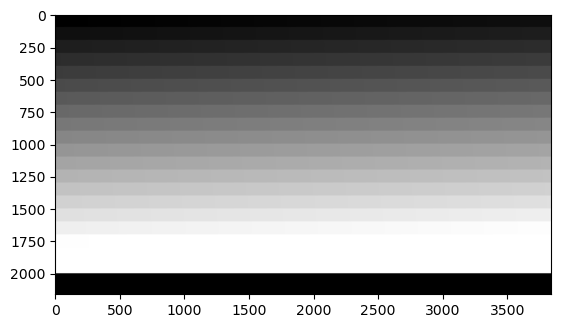

In [518]:
plt.imshow(test_bild_uhd_clipped/65535)

In [517]:
for i in range(0,2000,100):
    for x in range(100):
        test_bild_uhd[(1*i)+x,:,0] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        test_bild_uhd[(1*i)+x,:,1] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        test_bild_uhd[(1*i)+x,:,2] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        # test_bild_uhd[(1*i)+x+25,:,1] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        # test_bild_uhd[(1*i)+x+50,:,2] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        # test_bild_uhd[(1*i)+x+75,:,0] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        # test_bild_uhd[(1*i)+x+75,:,1] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)
        # test_bild_uhd[(1*i)+x+75,:,2] = np.linspace(3840*(i/100),3839*((i/100)+1)+(i/100),3840)

        print((1*i)+x)
        print(test_bild_uhd[(1*i)+x,:,0])
test_bild_uhd_clipped = np.clip(test_bild_uhd,0,65535)

0
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
1
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
2
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
3
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
4
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
5
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
6
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
7
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.83900000e+03]
8
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   3.83700000e+03
   3.83800000e+03   3.839000

In [38]:
for i in range(0,3800,100):
    for x in range(25):
        test_bild_uhd2[(1*i)+x,:,0] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)
        test_bild_uhd2[(1*i)+x+25,:,1] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)
        test_bild_uhd2[(1*i)+x+50,:,2] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)
        test_bild_uhd2[(1*i)+x+75,:,0] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)
        test_bild_uhd2[(1*i)+x+75,:,1] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)
        test_bild_uhd2[(1*i)+x+75,:,2] = np.linspace(7680*(i/100),7679*((i/100)+1)+(i/100),7680)

        print((1*i)+x)
        print(test_bild_uhd2[(1*i)+x,:,0])
test_bild_uhd_clipped2 = np.clip(test_bild_uhd2,0,262144)

0
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
1
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
2
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
3
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
4
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
5
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
6
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
7
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.67900000e+03]
8
[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   7.67700000e+03
   7.67800000e+03   7.679000

In [158]:
np.max(test_bild_uhd_clipped2)

262144.0

In [170]:
test_bild_uhd_scaled_3 = np.divide(test_bild_uhd_clipped2,262144)

In [26]:
np.max(test_bild_uhd_clipped)

65535.0

In [137]:
test_bild_uhd_scaled_pq2 = np.divide(np.round((test_bild_uhd_clipped/2),0)*2,65535)

In [159]:
c.write_image(test_bild_uhd_clipped/65535,"/Users/justus/Desktop/Testbild_Linear_16bit.tif",bit_depth="uint16")

In [131]:
np.max(test_bild_uhd_scaled_pq)

1.0

In [3]:
test_benchmark = c.read_image("/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_UHD/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/1_B002C026_220414_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C026_220414_B09C.00000000.tif",bit_depth="uint16")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [4]:
import numpy as np

# Reshape the 3D array into a 2D array with the third dimension as columns
reshapedArray = test_benchmark.reshape(-1, test_benchmark.shape[2])

# Find unique values in the reshaped array
uniqueValues = np.unique(reshapedArray)

# Display the number of unique values
numUniqueValues = len(uniqueValues)
print('Number of different values:', numUniqueValues)


Number of different values: 37801


In [129]:
import numpy as np

# Reshape the 3D array into a 2D array with the third dimension as columns
reshapedArray = test_benchmark.reshape(-1, test_benchmark.shape[2])

# Find unique values in the reshaped array
uniqueValues = np.unique(reshapedArray)

# Display the number of unique values
numUniqueValues = len(uniqueValues)
print('Number of different values:', numUniqueValues)


Number of different values: 65536


In [136]:
c.write_image(test_bild_uhd_scaled_pq,"/Users/justus/Desktop/Testbild_UHD_PQ_16bit.tif",bit_depth="uint16")

NameError: name 'test_bild_uhd_scaled_pq' is not defined

In [21]:
plt.imshow(test_bild_uhd/np.max(test_bild_uhd_scaled_pq))

NameError: name 'test_bild_uhd' is not defined

In [93]:
np.max(test_benchmark)

65535

In [94]:
benchmark_clipped = np.clip(test_benchmark/65535,c.models.eotf_inverse_ST2084(0.005),c.models.eotf_inverse_ST2084(1000))

In [174]:
test_bild_uhd_scaled_lin = test_bild_uhd_scaled_3*1000

In [175]:
np.max(test_bild_uhd_scaled_lin)

1000.0

In [161]:
test_bild_uhd_pq_10bit_narrow = np.zeros((2160,3840,3))
test_bild_uhd_hlg_10bit_narrow = np.zeros((2160,3840,3))

In [162]:
test_bild_uhd_pq_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_ST2084(test_bild_uhd_clipped/65535*12.5)),0),1023)
test_bild_uhd_pq_10bit_narrow[3700:3800,:,:] = 1

In [163]:
test_bild_uhd_hlg_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(test_bild_uhd_clipped/65535*12.5,0,1000)),0),1023)
test_bild_uhd_hlg_10bit_narrow[3700:3800,:,:] = 1

/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1525: RuntimeWarning: divide by zero encountered in power
  Y_D_alpha = np.abs(Y_D / alpha) ** ((1 - gamma) / gamma)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1530: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * R_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1535: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * G_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1540: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * B_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/arib_std_b67.py:115: RuntimeWarning: invalid value encountered in log
  E <= 1, r * gamma_function(E, 0.5, "mirror"), a * np.log

In [167]:
c.write_image(test_bild_uhd_pq_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_pq_10bit_narrow_125.tif")
c.write_image(test_bild_uhd_hlg_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_hlg_10bit_narrow_125.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [203]:
test_bild_uhd_pq_10bit_narrow2 = np.zeros((2160,3840,3))
test_bild_uhd_hlg_10bit_narrow2 = np.zeros((2160,3840,3))

In [462]:
test_lower = np.clip(test_bild_uhd_clipped/65535*12.5,0.005,12.5)

In [463]:
test_upper = np.clip(((test_bild_uhd_clipped/65535)*(987.5)+12.5),12.5,1000)

In [464]:
test_bild_uhd_pq_10bit_narrow2 = np.divide(np.round(full2legal(c.models.eotf_inverse_ST2084(test_upper)),0),1023)
test_bild_uhd_pq_10bit_narrow2[3700:3800,:,:] = 1

In [465]:
test_bild_uhd_hlg_10bit_narrow2 = np.divide(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(test_upper)),0),1023)
test_bild_uhd_hlg_10bit_narrow2[3700:3800,:,:] = 1

In [466]:
test_bild_uhd_pq_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_ST2084(test_lower)),0),1023)
test_bild_uhd_pq_10bit_narrow[3700:3800,:,:] = 1

In [467]:
test_bild_uhd_hlg_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(test_lower)),0),1023)
test_bild_uhd_hlg_10bit_narrow[3700:3800,:,:] = 1

In [468]:
np.min(test_bild_uhd_hlg_10bit_narrow)

0.071358748778103623

In [471]:
c.models.eotf_HLG_BT2100(legal2full(np.min(test_bild_uhd_hlg_10bit_narrow)*1023))

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "Recommendation ITU-R BT.2100" "Reference HLG OOTF" uses RGB Luminance in computations and expects a vector input, thus the given input array will be stacked to compose a vector for internal computations but a single component will be output.
  warn(*args, **kwargs)


0.0045250841737932259

In [441]:
c.write_image(test_bild_uhd_pq_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_pq_10bit_narrow_lower.tif")
c.write_image(test_bild_uhd_hlg_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_hlg_10bit_narrow_lower.tif")

In [477]:
import csv

# Assuming your array is a 3840x2160 2D list (nested list)
# Replace this with your actual array
your_array = test_bild_uhd_pq_10bit_narrow[:,:,0]

# Specify the file path where you want to save the CSV file
csv_file_path = '/Users/justus/Desktop/test_bild_uhd_pq_10bit_narrow_lower.csv'

# Open the file in write mode with newline='' to ensure proper line endings
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write each row of the array to the CSV file
    for row in your_array:
        csv_writer.writerow(row)

print(f"CSV file '{csv_file_path}' has been created.")


CSV file '/Users/justus/Desktop/test_bild_uhd_pq_10bit_narrow_lower.csv' has been created.


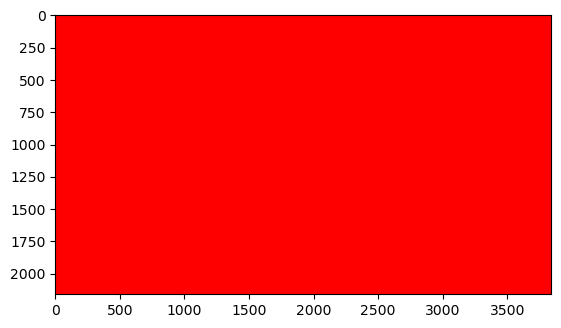

In [242]:
delta_e_array = delta_E_ITP_calculation(test_lower,c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow2*1023),0,1000))

delta_e_image = delta_E_ITP_visualisation(delta_e_array,test_bild_uhd_hlg_10bit_narrow2,1)
plt.imshow(delta_e_image)

In [478]:
delta_e_array_upper = delta_E_ITP_calculation(np.clip(c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow2*1023),0,1000),0.005,1000),np.clip(c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow2*1023)),0.005,1000))
delta_e_array_lower = delta_E_ITP_calculation(np.clip(c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow*1023),0,1000),0.005,1000),np.clip(c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow*1023)),0.005,1000))

In [479]:
delta_e_array_source_pq_lower = delta_E_ITP_calculation(np.clip(test_lower,0.005,1000),np.clip(c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow*1023)),0.005,1000))
delta_e_array_source_pq_upper = delta_E_ITP_calculation(np.clip(test_upper,0.005,1000),np.clip(c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow2*1023)),0.005,1000))

In [480]:
delta_e_array_source_hlg_lower = delta_E_ITP_calculation(np.clip(test_lower,0.005,1000),np.clip(c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow*1023),0,1000),0.005,1000))
delta_e_array_source_hlg_upper = delta_E_ITP_calculation(np.clip(test_upper,0.005,1000),np.clip(c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow2*1023),0,1000),0.005,1000))

In [485]:
delta_e_array_upper[100,:]

array([ 0.37984095,  0.37984095,  0.37984095, ...,  0.31266562,
        0.31266562,  0.31266562])

In [486]:
import numpy as np

# Assuming your array is named 'original_array' with shape (2160, 3840)
# Replace this with your actual array or data source

# Example:
original_array = np.random.random((2160, 3840))  # Replace this with your actual data

# Extract every 100th line
extracted_lines_upper = delta_e_array_upper[::100, :]
extracted_lines_lower = delta_e_array_lower[::100, :]

delta_e_pq_line_upper = delta_e_array_source_pq_upper[::100, :]
delta_e_pq_line_lower = delta_e_array_source_pq_lower[::100, :]
delta_e_hlg_line_upper = delta_e_array_source_hlg_upper[::100, :]
delta_e_hlg_line_lower = delta_e_array_source_hlg_lower[::100, :]

# Reshape the extracted lines into a one-dimensional array
one_dimensional_array_upper = extracted_lines_upper.flatten()
one_dimensional_array_lower = extracted_lines_lower.flatten()


delta_e_pq_line_upper_line = delta_e_pq_line_upper.flatten()
delta_e_pq_line_lower_line = delta_e_pq_line_lower.flatten()
delta_e_hlg_line_upper_line = delta_e_hlg_line_upper.flatten()
delta_e_hlg_line_lower_line = delta_e_hlg_line_lower.flatten()

In [492]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/PQ_HLG_upper.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_upper = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [493]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/PQ_HLG_lower.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_lower = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [494]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/Ref_PQ_lower.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_source_pq_lower = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [495]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/Ref_PQ_upper.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_source_pq_upper = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [496]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/Ref_HLG_upper.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_source_hlg_upper = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [497]:
import csv
import numpy as np

# Specify the path to your CSV file
csv_file_path = '/Users/justus/Desktop/Ref_HLG_lower.csv'

# Read the CSV file into a list of lists
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    csv_data = [list(map(float, row)) for row in csv_reader]

# Convert the list of lists to a NumPy array
ml_delta_e_array_source_hlg_lower = np.array(csv_data)

# Display the shape of the resulting array
print("Shape of the array:", image_array.shape)


Shape of the array: (2160, 3840)


In [510]:
ml_delta_e_array_lower[20,30]

-8.0810161622757394e-05

In [500]:
ml_extracted_lines_upper = ml_delta_e_array_upper[49::100, :]
ml_extracted_lines_lower = ml_delta_e_array_lower[49::100, :]

ml_delta_e_pq_line_upper = ml_delta_e_array_source_pq_upper[49::100, :]
ml_delta_e_pq_line_lower = ml_delta_e_array_source_pq_lower[49::100, :]
ml_delta_e_hlg_line_upper = ml_delta_e_array_source_hlg_upper[49::100, :]
ml_delta_e_hlg_line_lower = ml_delta_e_array_source_hlg_lower[49::100, :]

# Reshape the extracted lines into a one-dimensional array
ml_one_dimensional_array_upper = ml_extracted_lines_upper.flatten()
ml_one_dimensional_array_lower = ml_extracted_lines_lower.flatten()


ml_delta_e_pq_line_upper_line = ml_delta_e_pq_line_upper.flatten()
ml_delta_e_pq_line_lower_line = ml_delta_e_pq_line_lower.flatten()
ml_delta_e_hlg_line_upper_line = ml_delta_e_hlg_line_upper.flatten()
ml_delta_e_hlg_line_lower_line = ml_delta_e_hlg_line_lower.flatten()

In [490]:
np.shape(delta_e_hlg_line_lower_line)

(84480,)

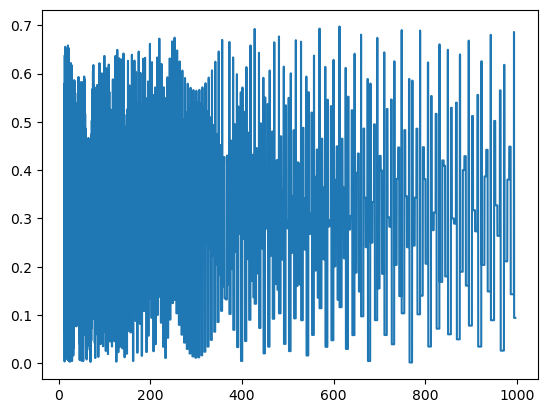

In [297]:
plt.plot(np.linspace(12.5,len(one_dimensional_array_upper)/len(one_dimensional_array_upper)*1000-(x/len(one_dimensional_array_upper)*16.4),len(one_dimensional_array_upper)-x),one_dimensional_array_upper[0:len(one_dimensional_array_upper)-x])

In [295]:
x=19500

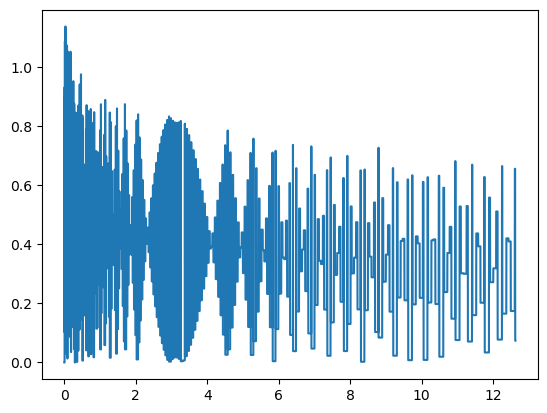

In [296]:
plt.plot(np.linspace(0.005,len(one_dimensional_array_lower)/len(one_dimensional_array_lower)*16.4-(x/len(one_dimensional_array_lower)*16.4),len(one_dimensional_array_lower)-x),one_dimensional_array_lower[0:len(one_dimensional_array_lower)-x])

In [287]:
np.max(one_dimensional_array)

0.69746140013846381

In [206]:
import numpy as np

# Reshape the 3D array into a 2D array with the third dimension as columns
reshapedArray = test_bild_uhd_pq_10bit_narrow2.reshape(-1, test_bild_uhd_pq_10bit_narrow2.shape[2])

# Find unique values in the reshaped array
uniqueValues = np.unique(reshapedArray)

# Display the number of unique values
numUniqueValues = len(uniqueValues)
print('Number of different values:', numUniqueValues)


Number of different values: 382


In [218]:
import numpy as np

# Reshape the 3D array into a 2D array with the third dimension as columns
reshapedArray = test_bild_uhd_hlg_10bit_narrow2.reshape(-1, test_bild_uhd_hlg_10bit_narrow2.shape[2])

# Find unique values in the reshaped array
uniqueValues = np.unique(reshapedArray)

# Display the number of unique values
numUniqueValues = len(uniqueValues)
print('Number of different values:', numUniqueValues)


Number of different values: 633


In [ ]:
np.max(full)

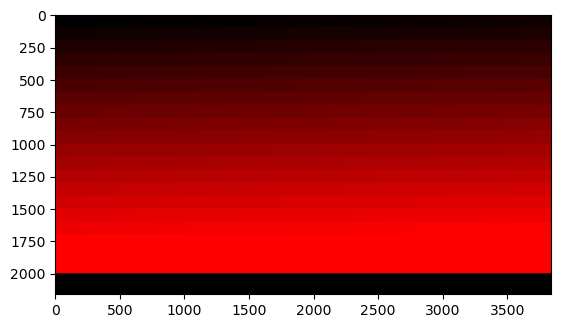

In [156]:
plt.imshow(test_bild_uhd_clipped/65535)

In [64]:
legal2full(2)

-0.070776255707762553

In [217]:
940-308

632

In [214]:
c.models.eotf_ST2084(legal2full(342))

12.465795298704752

In [119]:
c.models.eotf_HLG_BT2100(legal2full(308),0,1000)

12.450311653869786

In [216]:
c.models.eotf_HLG_BT2100(legal2full(940),0,1000)

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "Recommendation ITU-R BT.2100" "Reference HLG OOTF" uses RGB Luminance in computations and expects a vector input, thus the given input array will be stacked to compose a vector for internal computations but a single component will be output.
  warn(*args, **kwargs)


1000.0000323217691

In [33]:
c.write_image(test_bild_uhd_pq_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_pq_10bit_narrow.tif",bit_depth="uint16")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [34]:
c.write_image(test_bild_uhd_hlg_10bit_narrow,"/Users/justus/Desktop/test_bild_uhd_hlg_10bit_narrow.tif",bit_depth="uint16")

In [165]:
np.max(test_bild_uhd_pq_10bit_narrow)

0.27663734115347016

In [103]:
legal2full(940)

1.0

In [221]:
def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

from math import log10, sqrt 
import cv2 
import numpy as np
from skimage.metrics import structural_similarity as ssim_calculation

def PSNR_calculation(original, compressed): 

	# Expects Luma Images
	mse = mse_calculation(original,compressed)
	if(mse == 0): # MSE is zero means no noise is present in the signal . 
				# Therefore PSNR have no importance. 
		return 100
	max_pixel = 1023.0
	psnr = 20 * log10(max_pixel / sqrt(mse)) 
	return psnr 

def delta_E_ITP_calculation(original,compressed):

	# Recommendation ITU-R BT.2124-0
	# Expects Display-Linear RGB with 1 = 1 cd/m2
	L1 = (1688*original[:,:,0] + 2146*original[:,:,1] + 262*original[:,:,2])/4096
	M1 = (683*original[:,:,0] + 2951*original[:,:,1] + 462*original[:,:,2])/4096
	S1 = (99*original[:,:,0] + 309*original[:,:,1] + 3688*original[:,:,2])/4096

	L1_Mapped = c.models.eotf_inverse_ST2084(L1)
	M1_Mapped = c.models.eotf_inverse_ST2084(M1)
	S1_Mapped = c.models.eotf_inverse_ST2084(S1)

	I1 = 0.5*L1_Mapped+0.5*M1_Mapped
	CT1 =(6610*L1_Mapped - 13613*M1_Mapped + 7003*S1_Mapped)/4096
	CP1 =(17933*L1_Mapped - 17390*M1_Mapped - 543+S1_Mapped)/4096

	I1 = I1
	T1 = 0.5 * CT1
	P1 = CP1

	L2 = (1688*compressed[:,:,0] + 2146*compressed[:,:,1] + 262*compressed[:,:,2])/4096
	M2 = (683*compressed[:,:,0] + 2951*compressed[:,:,1] + 462*compressed[:,:,2])/4096
	S2 = (99*compressed[:,:,0] + 309*compressed[:,:,1] + 3688*compressed[:,:,2])/4096

	L2_Mapped = c.models.eotf_inverse_ST2084(L2)
	M2_Mapped = c.models.eotf_inverse_ST2084(M2)
	S2_Mapped = c.models.eotf_inverse_ST2084(S2)

	I2 = 0.5*L2_Mapped+0.5*M2_Mapped
	CT2 =(6610*L2_Mapped - 13613*M2_Mapped + 7003*S2_Mapped)/4096
	CP2 =(17933*L2_Mapped - 17390*M2_Mapped - 543+S2_Mapped)/4096

	I2 = I2
	T2 = 0.5 * CT2
	P2 = CP2

	return np.multiply(720,np.sqrt(np.add(np.power(np.subtract(I1,I2),2),np.add(np.power(np.subtract(T1,T2),2),np.power(np.subtract(P1,P2),2)))))

def delta_E_ITP_visualisation(delta_array, image, factor):
    container = np.zeros((len(delta_array[:, 0]), len(delta_array[0, :]), 3))
    mask1 = 1 >= delta_array
    mask2 = 1 <= delta_array
    mask3 = 2 < delta_array
    mask4 = 3 < delta_array
    mask5 = 4 < delta_array
    mask6 = 5 < delta_array
    mask7 = 6 < delta_array
    mask8 = 7 < delta_array
    mask9 = 8 < delta_array


    container[mask1] = [0, 0, 1]
    container[mask2] = [0, 0.5, 1]
    container[mask3] = [0, 1, 1]
    container[mask4] = [0, 1, 0.5]
    container[mask5] = [0, 1, 0]
    container[mask6] = [0.5, 1, 0]
    container[mask7] = [1, 1, 0]
    container[mask8] = [1, 0.5, 0]
    container[mask9] = [1, 0, 0]

    return image * (1 - factor) + container * factor

# SSIM expects Luma Values!!
def Auswertung_Encoding_PQ_UHD(ref,ref_encoding,comp,comp_encoding,factor,target,L_min_hlg=0,L_max_hlg=1000):

    ref_name = ref
    comp_name = comp

    ref = c.read_image(ref)
    comp = c.read_image(comp)

    if ref_encoding == "pq_full":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(ref,1023),4),1023)),0,100000)

    elif ref_encoding == "pq_narrow":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023)),0,100000)

    elif ref_encoding == "hlg_full":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(ref,1023),4),1023),L_min_hlg,1000),0,100000)

    elif ref_encoding == "hlg_narrow":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023),0,1000),0,100000)

    if comp_encoding == "pq_full":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(comp,1023),4),1023)),0,100000)

    elif comp_encoding == "pq_narrow":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023)),0,100000)

    elif comp_encoding == "hlg_full":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(comp,1023),4),1023),0,1000),0,100000)

    elif comp_encoding == "hlg_narrow":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023),0,1000),0,100000)

    ref_display_linear_luma2020 = luma2020(ref_display_linear)
    comp_display_linear_luma2020 = luma2020(comp_display_linear)

    # Calculation of MSE
    mse = np.round(mse_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of PSNR
    psnr = np.round(PSNR_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of SSIM
    ssim = np.round(ssim_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of Minimum delta E
    delta_e_array = delta_E_ITP_calculation(ref_display_linear,comp_display_linear)

    # Visualisation of Minimum delta E
    delta_e_image = delta_E_ITP_visualisation(delta_e_array,ref,factor)

    figR, (axR,axL) = plt.subplots(1, 2, figsize=(16, 16),gridspec_kw={'width_ratios': [len(delta_e_image[0,:,0]), len(delta_e_image[0,:,0])/32]})
    axR.imshow(delta_e_image)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"MSE: {mse}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"PSNR: {psnr}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"SSIM: {ssim}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8),"Reference:   " + ref_name,fontsize=7)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8)+(len(delta_e_image[:,0,0])/30),"Comparison:   " + comp_name,fontsize=7)

    legend = delta_e_image
    pos1_y = int(len(delta_e_image[:,0,0])/5*0)
    pos2_y = int(len(delta_e_image[:,0,0])/5*1)
    pos3_y = int(len(delta_e_image[:,0,0])/5*2)
    pos4_y = int(len(delta_e_image[:,0,0])/5*3)
    pos5_y = int(len(delta_e_image[:,0,0])/5*4)
    pos_y_max = int(len(delta_e_image[:,0,0]))
    legend[pos1_y:pos_y_max,:,:] = [1, 0, 0]
    legend[pos2_y:pos_y_max,:,:] = [1, 1, 0]
    legend[pos3_y:pos_y_max,:,:] = [0, 1, 0]
    legend[pos4_y:pos_y_max,:,:] = [0, 1, 1]
    legend[pos5_y:pos_y_max,:,:] = [0, 0, 1]

    height = int(len(delta_e_image[0,:,0])/32)
    axL.imshow(legend[:,0:height,:])
    marker = [pos1_y,pos2_y,pos3_y,pos4_y,pos5_y,pos_y_max]
    marker_content = ["inf",4,3,2,1,0]
    axL.set_yticks(marker,marker_content)
    axL.set_ylabel("delta E ITP")
    axL.set_xticks([],[])

    figR.savefig(target)
    figR.clf()
    plt.close(figR)

    csv_file_name = target + "_delta_E_map.csv"

    with open(csv_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in delta_e_array:
            writer.writerow(row)

def Auswertung_Encoding_PQ_HD(ref,ref_encoding,comp,comp_encoding,factor,target,L_min_hlg=0,L_max_hlg=1000):

    ref_name = ref
    comp_name = comp

    ref = c.read_image(ref)
    comp = c.read_image(comp)
    
    if ref_encoding == "pq_full":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(ref,1023),4),1023)),0,100000)

    elif ref_encoding == "pq_narrow":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023)),0,100000)

    elif ref_encoding == "hlg_full":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(ref,1023),4),1023),L_min_hlg,1000),0,100000)

    elif ref_encoding == "hlg_narrow":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023),0,1000),0,100000)

    if comp_encoding == "pq_full":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(comp,1023),4),1023)),0,100000)

    elif comp_encoding == "pq_narrow":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023)),0,100000)

    elif comp_encoding == "hlg_full":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(comp,1023),4),1023),0,1000),0,100000)

    elif comp_encoding == "hlg_narrow":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023),0,1000),0,100000)

    ref_display_linear_luma2020 = luma2020(ref_display_linear)
    comp_display_linear_luma2020 = luma2020(comp_display_linear)

    # Calculation of MSE
    mse = np.round(mse_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of PSNR
    psnr = np.round(PSNR_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of SSIM
    ssim = np.round(ssim_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of Minimum delta E
    delta_e_array = delta_E_ITP_calculation(ref_display_linear,comp_display_linear)

    # Visualisation of Minimum delta E
    delta_e_image = delta_E_ITP_visualisation(delta_e_array,ref,factor)

    figR, (axR,axL) = plt.subplots(1, 2, figsize=(16, 16),gridspec_kw={'width_ratios': [len(delta_e_image[0,:,0]), len(delta_e_image[0,:,0])/32]})
    axR.imshow(delta_e_image)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"MSE: {mse}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"PSNR: {psnr}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"SSIM: {ssim}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8),"Reference:   " + ref_name,fontsize=7)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8)+(len(delta_e_image[:,0,0])/30),"Comparison:   " + comp_name,fontsize=7)

    legend = delta_e_image
    pos1_y = int(len(delta_e_image[:,0,0])/5*0)
    pos2_y = int(len(delta_e_image[:,0,0])/5*1)
    pos3_y = int(len(delta_e_image[:,0,0])/5*2)
    pos4_y = int(len(delta_e_image[:,0,0])/5*3)
    pos5_y = int(len(delta_e_image[:,0,0])/5*4)
    pos_y_max = int(len(delta_e_image[:,0,0]))
    legend[pos1_y:pos_y_max,:,:] = [1, 0, 0]
    legend[pos2_y:pos_y_max,:,:] = [1, 1, 0]
    legend[pos3_y:pos_y_max,:,:] = [0, 1, 0]
    legend[pos4_y:pos_y_max,:,:] = [0, 1, 1]
    legend[pos5_y:pos_y_max,:,:] = [0, 0, 1]

    height = int(len(delta_e_image[0,:,0])/32)
    axL.imshow(legend[:,0:height,:])
    marker = [pos1_y,pos2_y,pos3_y,pos4_y,pos5_y,pos_y_max]
    marker_content = ["inf",4,3,2,1,0]
    axL.set_yticks(marker,marker_content)
    axL.set_ylabel("delta E ITP")
    axL.set_xticks([],[])

    figR.savefig(target)
    figR.clf()
    plt.close(figR)

    csv_file_name = target + "_delta_E_map.csv"

    with open(csv_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in delta_e_array:
            writer.writerow(row)

In [124]:
legal2full(940)

1.0

In [144]:
np.max(c.models.eotf_ST2084(test_bild_uhd_scaled_pq))

10000.0

In [ ]:
delta_e_array = delta_E_ITP_calculation(np.clip(test_bild_uhd_scaled_lin,0.005,1000),c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow*1023)))

delta_e_image = delta_E_ITP_visualisation(delta_e_array,test_bild_uhd_scaled_lin,1)
plt.imshow(delta_e_image)

In [181]:
np.min(delta_e_array)

1.4911295520744462e-06

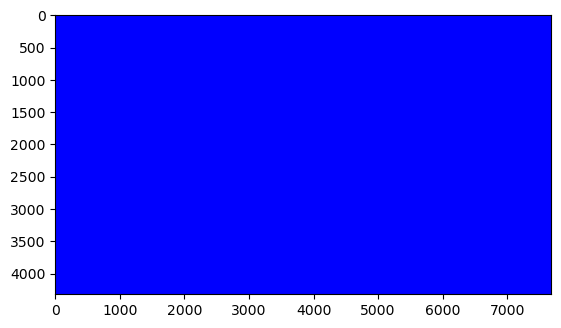

In [179]:

delta_e_image = delta_E_ITP_visualisation(delta_e_array,test_bild_uhd_scaled_lin,1)
plt.imshow(delta_e_image)

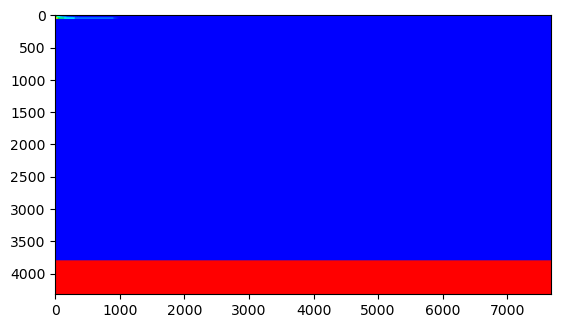

In [182]:
delta_e_array = delta_E_ITP_calculation(test_bild_uhd_scaled_lin,c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow*1023),0,1000))

delta_e_image = delta_E_ITP_visualisation(delta_e_array,test_bild_uhd_scaled_lin,1)
plt.imshow(delta_e_image)

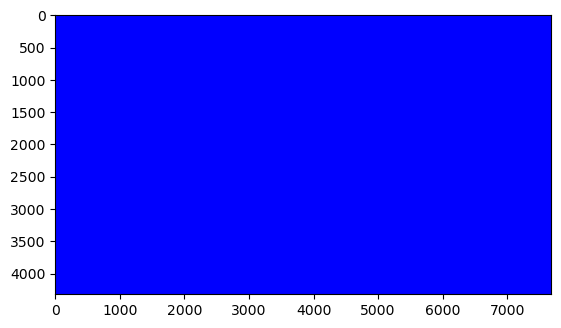

In [184]:
delta_e_array = delta_E_ITP_calculation(c.models.eotf_ST2084(legal2full(test_bild_uhd_pq_10bit_narrow*1023)),c.models.eotf_HLG_BT2100(legal2full(test_bild_uhd_hlg_10bit_narrow*1023),0,1000))

delta_e_image = delta_E_ITP_visualisation(delta_e_array,test_bild_uhd_pq_10bit_narrow,1)
plt.imshow(delta_e_image)

In [186]:
np.min(delta_e_array)

9.8278539542147339e-05

In [378]:
luminance_array_red = np.zeros((1,65535,3))
luminance_array_red[0,:,0]= np.logspace(-2.26,3,65535)

In [379]:
luminance_array_green = np.zeros((1,65535,3))
luminance_array_green[0,:,1]= np.logspace(-2.26,3,65535)

In [380]:
luminance_array_blue = np.zeros((1,65535,3))
luminance_array_blue[0,:,2]= np.logspace(-2.26,3,65535)

In [381]:
luminance_array_luma = np.zeros((1,65535,3))
luminance_array_luma[0,:,0]= np.logspace(-2.26,3,65535)
luminance_array_luma[0,:,1]= np.logspace(-2.26,3,65535)
luminance_array_luma[0,:,2]= np.logspace(-2.26,3,65535)

In [382]:
pq_10bit_narrow_red = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_ST2084(luminance_array_red)),0),64,940),1023)
pq_10bit_narrow_green = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_ST2084(luminance_array_green)),0),64,940),1023)
pq_10bit_narrow_blue = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_ST2084(luminance_array_blue)),0),64,940),1023)
pq_10bit_narrow_luma = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_ST2084(luminance_array_luma)),0),64,940),1023)

In [383]:
hlg_10bit_narrow_red = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(luminance_array_red,0,1000)),0),64,940),1023)
hlg_10bit_narrow_green = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(luminance_array_green,0,1000)),0),64,940),1023)
hlg_10bit_narrow_blue = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(luminance_array_blue,0,1000)),0),64,940),1023)
hlg_10bit_narrow_luma = np.divide(np.clip(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(luminance_array_luma,0,1000)),0),64,940),1023)

In [384]:
pq_10bit_narrow_red_lin = c.models.eotf_ST2084(legal2full(pq_10bit_narrow_red*1023))
pq_10bit_narrow_green_lin = c.models.eotf_ST2084(legal2full(pq_10bit_narrow_green*1023))
pq_10bit_narrow_blue_lin = c.models.eotf_ST2084(legal2full(pq_10bit_narrow_blue*1023))
pq_10bit_narrow_luma_lin = c.models.eotf_ST2084(legal2full(pq_10bit_narrow_luma*1023))

In [385]:
hlg_10bit_narrow_red_lin = c.models.eotf_HLG_BT2100(legal2full(hlg_10bit_narrow_red*1023),0,1000)
hlg_10bit_narrow_green_lin = c.models.eotf_HLG_BT2100(legal2full(hlg_10bit_narrow_green*1023),0,1000)
hlg_10bit_narrow_blue_lin = c.models.eotf_HLG_BT2100(legal2full(hlg_10bit_narrow_blue*1023),0,1000)
hlg_10bit_narrow_luma_lin = c.models.eotf_HLG_BT2100(legal2full(hlg_10bit_narrow_luma*1023),0,1000)

In [386]:
pq_10bit_narrow_delta_e_array_red = delta_E_ITP_calculation(luminance_array_red,pq_10bit_narrow_red_lin)
pq_10bit_narrow_delta_e_array_green = delta_E_ITP_calculation(luminance_array_green,pq_10bit_narrow_green_lin)
pq_10bit_narrow_delta_e_array_blue = delta_E_ITP_calculation(luminance_array_blue,pq_10bit_narrow_blue_lin)
pq_10bit_narrow_delta_e_array_luma = delta_E_ITP_calculation(luminance_array_luma,pq_10bit_narrow_luma_lin)

In [387]:
hlg_10bit_narrow_delta_e_array_red = delta_E_ITP_calculation(luminance_array_red,hlg_10bit_narrow_red_lin)
hlg_10bit_narrow_delta_e_array_green = delta_E_ITP_calculation(luminance_array_green,hlg_10bit_narrow_green_lin)
hlg_10bit_narrow_delta_e_array_blue = delta_E_ITP_calculation(luminance_array_blue,hlg_10bit_narrow_blue_lin)
hlg_10bit_narrow_delta_e_array_luma = delta_E_ITP_calculation(luminance_array_luma,hlg_10bit_narrow_luma_lin)

In [388]:
hlg_pq_10bit_narrow_delta_e_array_luma = delta_E_ITP_calculation(pq_10bit_narrow_luma_lin,hlg_10bit_narrow_luma_lin)

In [374]:
np.shape(hlg_pq_10bit_narrow_delta_e_array_luma)

(1, 65535)

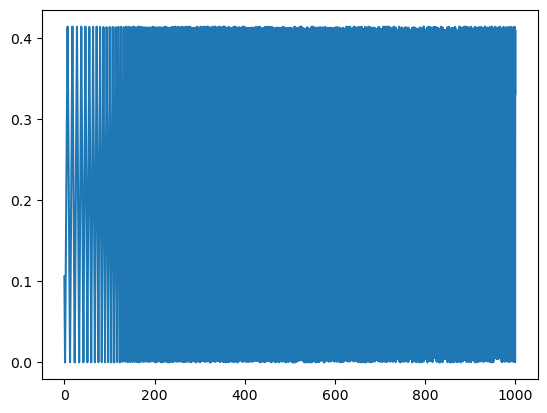

In [376]:
plt.plot(np.linspace(0.005,1000,65535),pq_10bit_narrow_delta_e_array_luma[0,:])

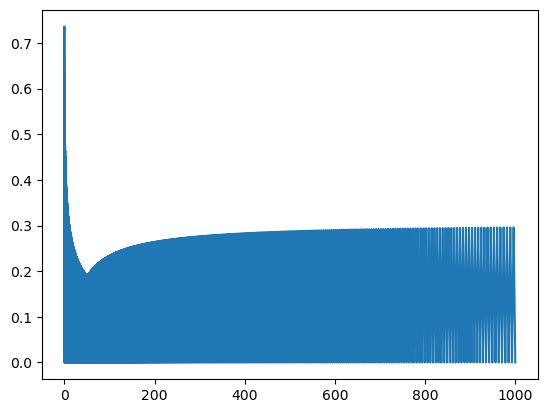

In [281]:
plt.plot(np.linspace(0.005,1000,1048576),hlg_10bit_narrow_delta_e_array_luma[0,:])

In [283]:
np.linspace(64,940,877)

array([  64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,  135.,
        136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,  144.,
        145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,  153.,
        154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,  162.,
        163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,  171.,
        172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,  180.,
        181.,  182.,  183.,  184.,  185.,  186.,  187.,  188.,  189.,
        190.,  191.,

In [285]:
np.linspace(64,722,659)

array([  64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,  135.,
        136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,  144.,
        145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,  153.,
        154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,  162.,
        163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,  171.,
        172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,  180.,
        181.,  182.,  183.,  184.,  185.,  186.,  187.,  188.,  189.,
        190.,  191.,

Text(832, 0.6, '1000 cd/m2 Limit BT.2100 Ref. Display')

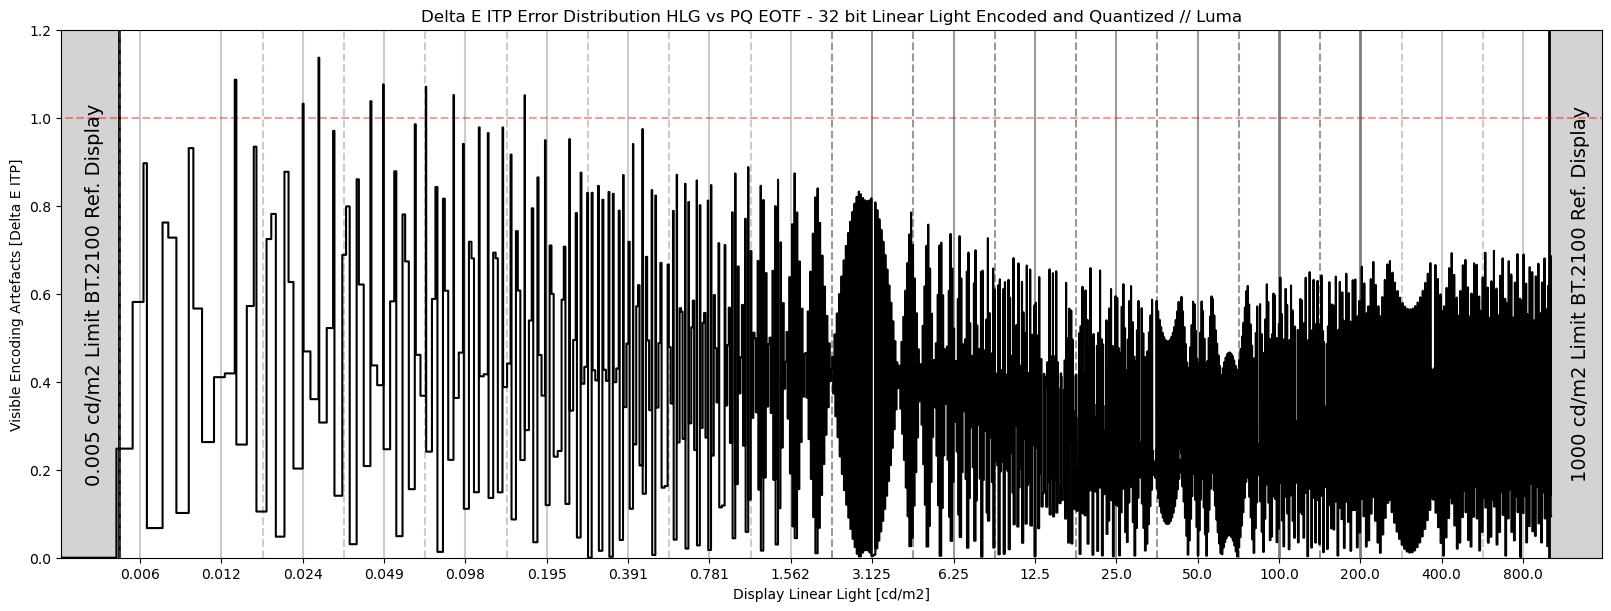

In [487]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Visible Encoding Artefacts [Delta E ITP]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)



# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.step(np.linspace(0,len(one_dimensional_array_lower)/len(one_dimensional_array_lower)*10-(x/len(one_dimensional_array_lower)*10),len(one_dimensional_array_lower)-x),one_dimensional_array_lower[0:len(one_dimensional_array_lower)-x],color="black")
axL1.step(np.linspace(7.8,len(one_dimensional_array_upper)/len(one_dimensional_array_upper)*650-(x/len(one_dimensional_array_upper)),len(one_dimensional_array_upper)-x),one_dimensional_array_upper[0:len(one_dimensional_array_upper)-x],color="black")

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
# axL1.set_yscale("log")
axL1.set_ylim(0,1.2)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("Delta E ITP Error Distribution HLG vs PQ EOTF - 32 bit Linear Light Encoded and Quantized // Luma")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.6,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.6,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)


In [404]:
np.shape(delta_e_pq_line_lower_line)

(2160, 3840)

Text(832, 0.6, '1000 cd/m2 Limit BT.2100 Ref. Display')

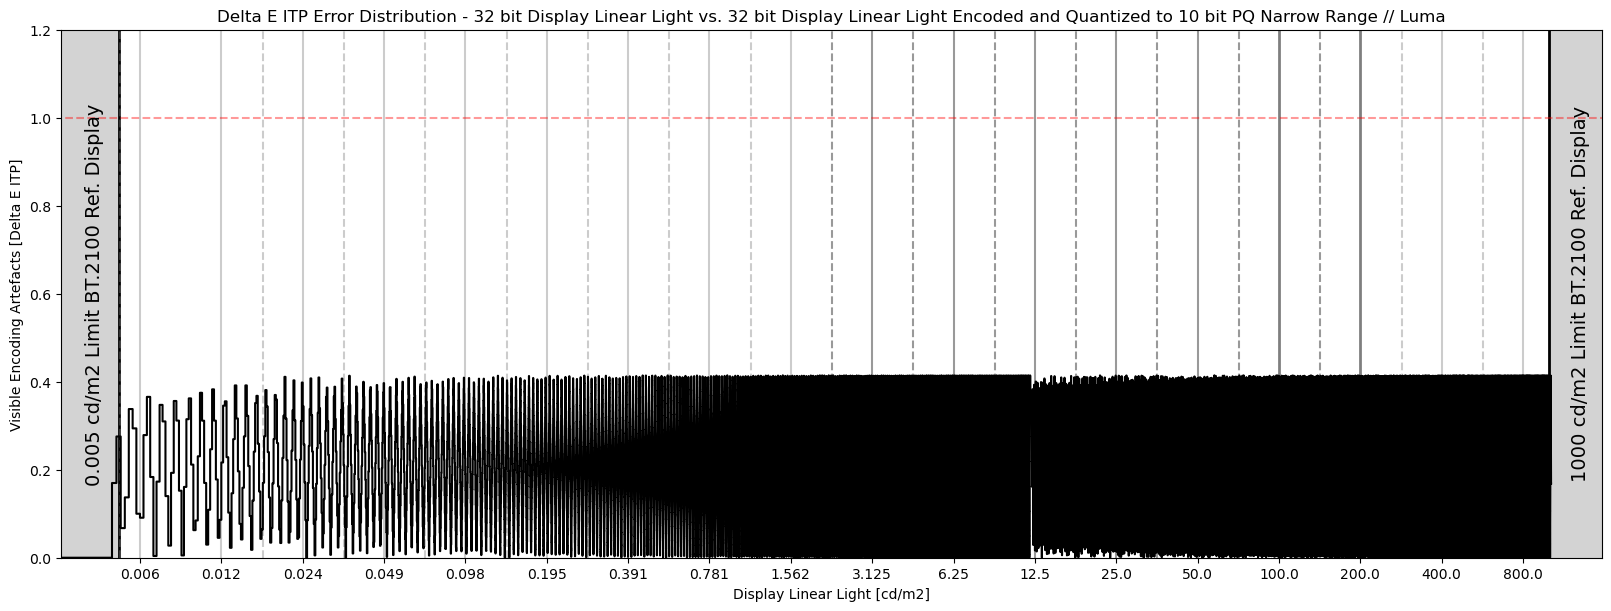

In [488]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Visible Encoding Artefacts [Delta E ITP]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)



# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.step(np.linspace(0,len(delta_e_pq_line_lower_line)/len(delta_e_pq_line_lower_line)*10-(x/len(delta_e_pq_line_lower_line)*10),len(delta_e_pq_line_lower_line)-x),delta_e_pq_line_lower_line[0:len(delta_e_pq_line_lower_line)-x],color="black")
axL1.step(np.linspace(7.8,len(delta_e_pq_line_upper_line)/len(delta_e_pq_line_upper_line)*650-(x/len(delta_e_pq_line_upper_line)),len(delta_e_pq_line_upper_line)-x),delta_e_pq_line_upper_line[0:len(delta_e_pq_line_upper_line)-x],color="black")

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
# axL1.set_yscale("log")
axL1.set_ylim(0,1.2)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("Delta E ITP Error Distribution - 32 bit Display Linear Light vs. 32 bit Display Linear Light Encoded and Quantized to 10 bit PQ Narrow Range // Luma")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.6,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.6,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)

Text(832, 0.6, '1000 cd/m2 Limit BT.2100 Ref. Display')

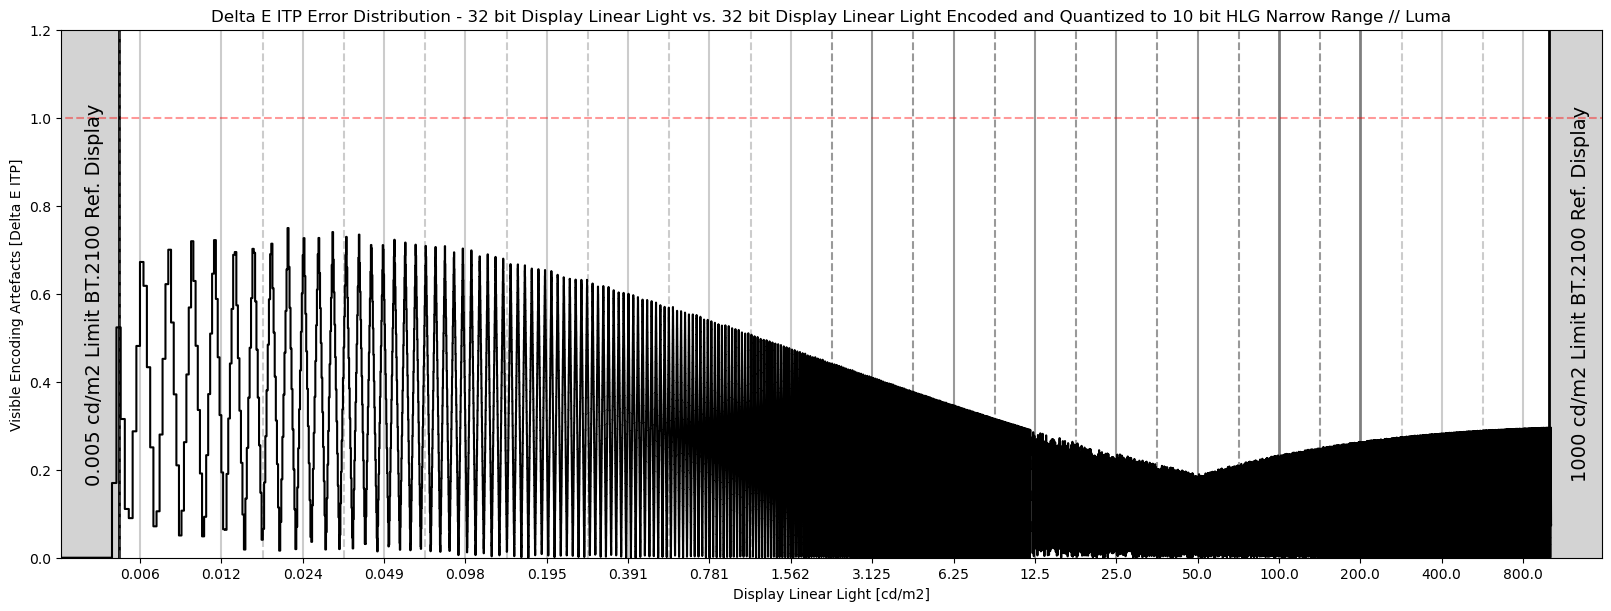

In [489]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Visible Encoding Artefacts [Delta E ITP]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)



# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.step(np.linspace(0,len(delta_e_hlg_line_lower_line)/len(delta_e_hlg_line_lower_line)*10-(x/len(delta_e_hlg_line_lower_line)*10),len(delta_e_hlg_line_lower_line)-x),delta_e_hlg_line_lower_line[0:len(delta_e_hlg_line_lower_line)-x],color="black")
axL1.step(np.linspace(7.8,len(delta_e_hlg_line_upper_line)/len(delta_e_hlg_line_upper_line)*650-(x/len(delta_e_hlg_line_upper_line)),len(delta_e_hlg_line_upper_line)-x),delta_e_hlg_line_upper_line[0:len(delta_e_hlg_line_upper_line)-x],color="black")

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
# axL1.set_yscale("log")
axL1.set_ylim(0,1.2)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("Delta E ITP Error Distribution - 32 bit Display Linear Light vs. 32 bit Display Linear Light Encoded and Quantized to 10 bit HLG Narrow Range // Luma")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.6,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.6,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)

Text(832, 0.6, '1000 cd/m2 Limit BT.2100 Ref. Display')

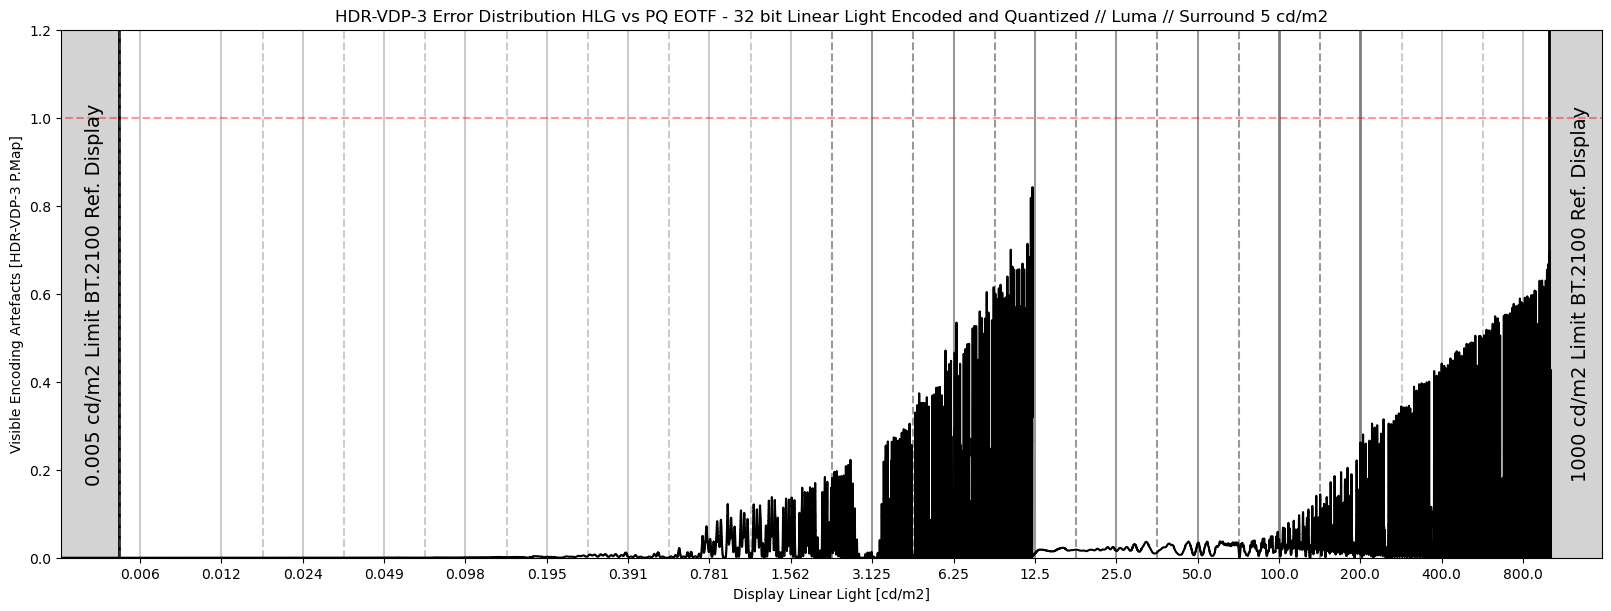

In [505]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Visible Encoding Artefacts [HDR-VDP-3 P.Map]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)



# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.step(np.linspace(0,len(ml_one_dimensional_array_lower)/len(ml_one_dimensional_array_lower)*10.2-(x/len(ml_one_dimensional_array_lower)*10.2),len(ml_one_dimensional_array_lower)-x),ml_one_dimensional_array_lower[0:len(ml_one_dimensional_array_lower)-x],color="black")
axL1.step(np.linspace(7.8,len(ml_one_dimensional_array_upper)/len(ml_one_dimensional_array_upper)*650-(x/len(ml_one_dimensional_array_upper)),len(ml_one_dimensional_array_upper)-x),ml_one_dimensional_array_upper[0:len(ml_one_dimensional_array_upper)-x],color="black")

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
# axL1.set_yscale("log")
axL1.set_ylim(0,1.2)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("HDR-VDP-3 Error Distribution HLG vs PQ EOTF - 32 bit Linear Light Encoded and Quantized // Luma // Surround 5 cd/m2")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.6,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.6,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)


Text(832, 0.6, '1000 cd/m2 Limit BT.2100 Ref. Display')

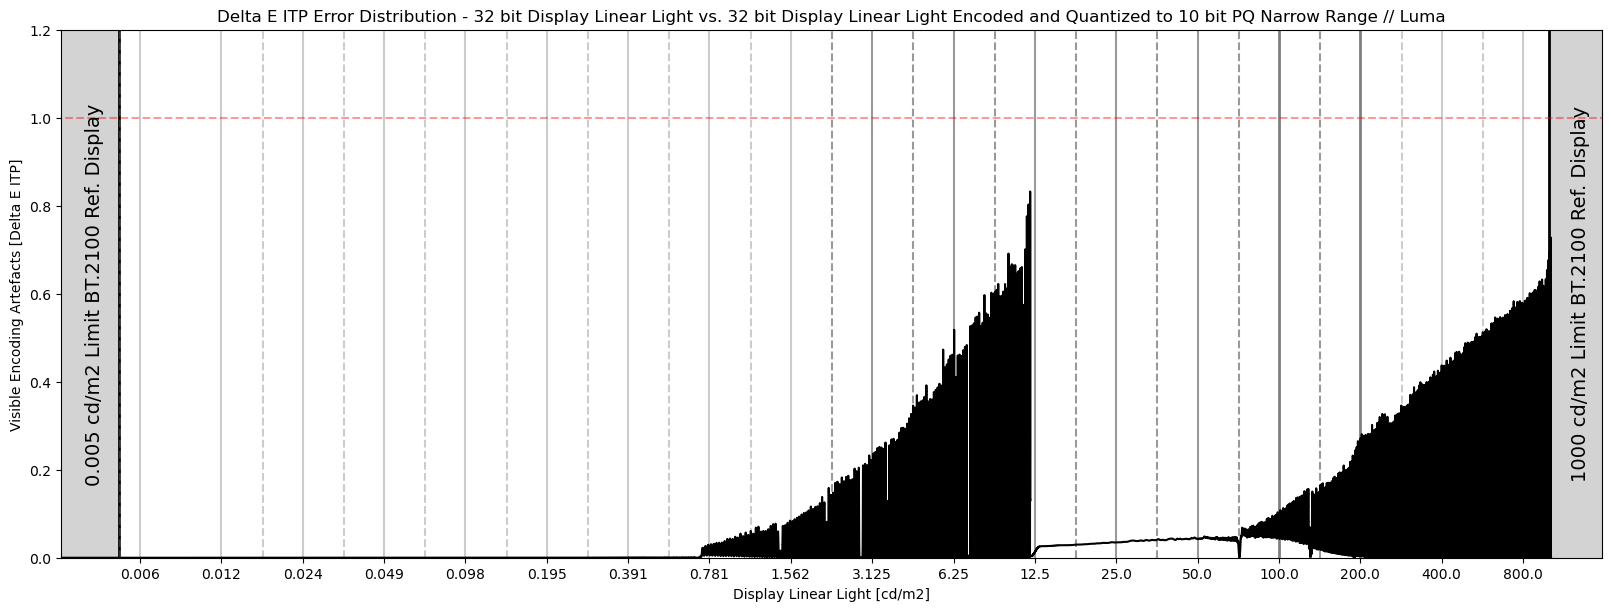

In [506]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Visible Encoding Artefacts [Delta E ITP]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)



# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.step(np.linspace(0,len(ml_delta_e_pq_line_lower_line)/len(ml_delta_e_pq_line_lower_line)*10-(x/len(ml_delta_e_pq_line_lower_line)*10),len(ml_delta_e_pq_line_lower_line)-x),ml_delta_e_pq_line_lower_line[0:len(ml_delta_e_pq_line_lower_line)-x],color="black")
axL1.step(np.linspace(7.8,len(ml_delta_e_pq_line_upper_line)/len(ml_delta_e_pq_line_upper_line)*650-(x/len(ml_delta_e_pq_line_upper_line)),len(ml_delta_e_pq_line_upper_line)-x),ml_delta_e_pq_line_upper_line[0:len(ml_delta_e_pq_line_upper_line)-x],color="black")

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
# axL1.set_yscale("log")
axL1.set_ylim(0,1.2)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("Delta E ITP Error Distribution - 32 bit Display Linear Light vs. 32 bit Display Linear Light Encoded and Quantized to 10 bit PQ Narrow Range // Luma")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.6,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.6,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)

In [ ]:
delta_e_pq_line_upper_line = delta_e_pq_line_upper
delta_e_pq_line_lower_line = delta_e_pq_line_lower
delta_e_hlg_line_upper_line = delta_e_hlg_line_upper
delta_e_hlg_line_lower_line = delta_e_hlg_line_lower

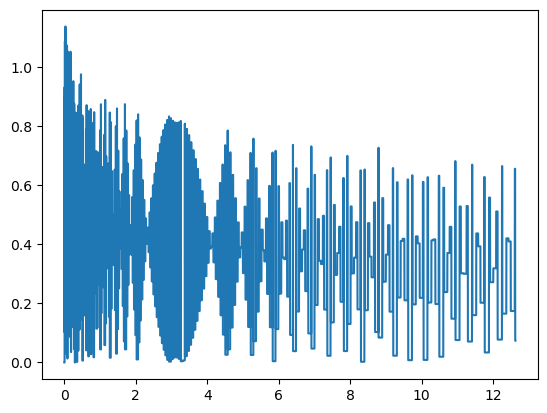

In [298]:
plt.plot(np.linspace(0.005,len(one_dimensional_array_lower)/len(one_dimensional_array_lower)*16.4-(x/len(one_dimensional_array_lower)*16.4),len(one_dimensional_array_lower)-x),one_dimensional_array_lower[0:len(one_dimensional_array_lower)-x])

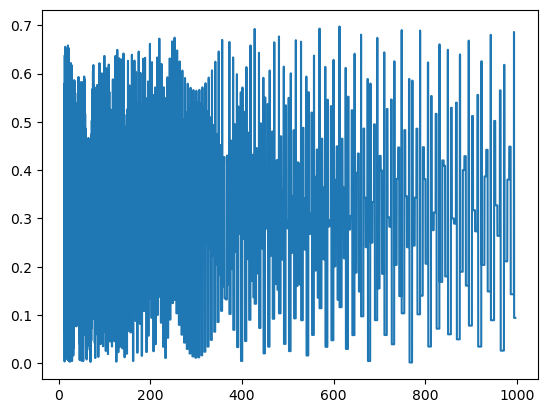

In [299]:
plt.plot(np.linspace(12.5,len(one_dimensional_array_upper)/len(one_dimensional_array_upper)*1000-(x/len(one_dimensional_array_upper)*16.4),len(one_dimensional_array_upper)-x),one_dimensional_array_upper[0:len(one_dimensional_array_upper)-x])

In [19]:
hlg_bild = np.zeros((1080,1920,3))
for i in range(1920):
    hlg_bild[0,0:877,0] = np.linspace(64,940,877)
    hlg_bild[0,0:877,1] = np.linspace(64,940,877)
    hlg_bild[0,0:877,2] = np.linspace(64,940,877)

In [20]:
pq_bild = np.zeros((1080,1920,3))
for i in range(1920):
    pq_bild[0,0:659,0] = np.linspace(64,722,659)
    pq_bild[0,0:659,1] = np.linspace(64,722,659)
    pq_bild[0,0:659,2] = np.linspace(64,722,659)

In [17]:
np.linspace(64,722,659)

array([  64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,  135.,
        136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,  144.,
        145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,  153.,
        154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,  162.,
        163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,  171.,
        172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,  180.,
        181.,  182.,  183.,  184.,  185.,  186.,  187.,  188.,  189.,
        190.,  191.,